## Bibliotecas

In [7]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Carregando Arquivo fonte

In [8]:
# Carregar o arquivo "NTNB.xlsx"
file_path = 'NTNB.xlsx'

# Carregar a aba "BBG", ignorando as primeiras 3 linhas, pois a linha 4 é o cabeçalho
df_original = pd.read_excel(file_path, sheet_name="BBG", skiprows=3)

# Selecionar as colunas de interesse
columns_of_interest = ['Dates', 'BRL', 'SELIC', 'IPCA + 6', 'NTN-B', 'TREASURY', 'CPI', 'TII', 'BOND BR']
df_selected = df_original[columns_of_interest].copy()

# Converter a coluna 'Dates' para datetime para garantir que está no formato correto
df_selected['Dates'] = pd.to_datetime(df_selected['Dates'], errors='coerce')

# Remover qualquer linha onde 'Dates' seja NaT (Not a Time), indicando erro de conversão
df_selected.dropna(subset=['Dates'], inplace=True)

## Filtros no Arquivo fonte e tratamento das variáveis

In [9]:
# Funções para calcular variações
def calculate_fx_rate_years(df, years):
    shift_value = 52 * years  # 52 semanas por ano
    df[f'FX_Rate_{years}_years'] = (df['BRL'].shift(-shift_value) / df['BRL']) - 1
    return df

def calculate_selic_years(df, years):
    shift_value = 52 * years  # 52 semanas por ano
    df[f'SELIC_Rate_{years}_years'] = ((1 + df[f'FX_Rate_{years}_years']) * 
                                       (df['SELIC'].shift(-shift_value) / df['SELIC'])) ** (1/years) - 1
    return df

def calculate_ipca_years(df, years):
    shift_value = 52 * years  # 52 semanas por ano
    df[f'IPCA_Rate_{years}_years'] = ((1 + df[f'FX_Rate_{years}_years']) * 
                                      ((1.06 ** years) * (df['IPCA + 6'].shift(-shift_value) / df['IPCA + 6']))) ** (1/years) - 1
    return df

def calculate_ntnb_years(df, years):
    shift_value = 52 * years  # 52 semanas por ano
    df[f'NTNB_Rate_{years}_years'] = (((1 + df[f'FX_Rate_{years}_years']) * 
                                       (((1 + df['NTN-B']) ** years) * 
                                       (df['IPCA + 6'].shift(-shift_value) / df['IPCA + 6']))) *
                                       (1 + (df['NTN-B'] - df['NTN-B'].shift(-shift_value)) * 10)) ** (1/years) - 1
    return df

def calculate_ff_years(df, years):
    shift_value = 52 * years  # 52 semanas por ano
    df[f'FF_Rate_{years}_years'] = (df['TREASURY'].shift(-shift_value) / df['TREASURY']) ** (1/years) - 1
    return df

def calculate_tip_years(df, years):
    shift_value = 52 * years  # 52 semanas por ano
    df[f'TIP_Rate_{years}_years'] = (((1 + df['TII']) ** years) * 
                                     (df['CPI'].shift(-shift_value) / df['CPI']) * 
                                     (1 + (df['TII'] - df['TII'].shift(-shift_value)) * 10)) ** (1/years) - 1
    return df

def calculate_bond_br_years(df, years):
    shift_value = 52 * years  # 52 semanas por ano
    df[f'BOND_Rate_{years}_years'] = (((1 + df['BOND BR']) ** years) * 
                                     (1 + (df['BOND BR'] - df['BOND BR'].shift(-shift_value)) * 10)) ** (1/years) - 1
    return df

# Função para calcular até a data mais recente
def calculate_to_current(df):
    most_recent_date = df['Dates'].max()
    days_diff = (most_recent_date - df['Dates']).dt.days / 365

    # FX Rate até a data atual
    df['FX_Rate_to_current'] = (df['BRL'].shift(-1) / df['BRL']) - 1

    # SELIC até a data atual
    df['SELIC_Rate_to_current'] = ((1 + df['FX_Rate_to_current']) * 
                                   (df['SELIC'].shift(-1) / df['SELIC'])) ** (1 / days_diff) - 1

    # IPCA + 6 até a data atual
    df['IPCA_Rate_to_current'] = ((1 + df['FX_Rate_to_current']) * 
                                   ((1.06 ** days_diff) * (df['IPCA + 6'].shift(-1) / df['IPCA + 6']))) ** (1 / days_diff) - 1

    # NTNB Longa até a data atual
    df['NTNB_Rate_to_current'] = (((1 + df['FX_Rate_to_current']) * 
                                    (((1 + df['NTN-B']) ** days_diff) * 
                                    (df['IPCA + 6'].shift(-1) / df['IPCA + 6']))) *
                                    (1 + (df['NTN-B'] - df['NTN-B'].shift(-1)) * 10)) ** (1 / days_diff) - 1

    # FF até a data atual
    df['FF_Rate_to_current'] = (df['TREASURY'].shift(-1) / df['TREASURY']) ** (1 / days_diff) - 1

    # TIP Longa até a data atual
    df['TIP_Rate_to_current'] = (((1 + df['TII']) ** days_diff) * 
                                  (df['CPI'].shift(-1) / df['CPI']) * 
                                  (1 + (df['TII'] - df['TII'].shift(-1)) * 10)) ** (1 / days_diff) - 1

    # BOND BR USD até a data atual
    df['BOND_Rate_to_current'] = (((1 + df['BOND BR']) ** days_diff) * 
                                  (1 + (df['BOND BR'] - df['BOND BR'].shift(-1)) * 10)) ** (1 / days_diff) - 1
    return df

# Aplicar as funções para 1, 3, 5, e 10 anos
for years in [1, 3, 5, 10]:
    df_selected = calculate_fx_rate_years(df_selected, years)
    df_selected = calculate_selic_years(df_selected, years)
    df_selected = calculate_ipca_years(df_selected, years)
    df_selected = calculate_ntnb_years(df_selected, years)
    df_selected = calculate_ff_years(df_selected, years)
    df_selected = calculate_tip_years(df_selected, years)
    df_selected = calculate_bond_br_years(df_selected, years)

    # Transformar todos os valores calculados em porcentagem e limitar a 1 casa decimal
    for col in [f'FX_Rate_{years}_years', f'SELIC_Rate_{years}_years', f'IPCA_Rate_{years}_years', f'NTNB_Rate_{years}_years', f'FF_Rate_{years}_years', f'TIP_Rate_{years}_years', f'BOND_Rate_{years}_years']:
        df_selected[col] = df_selected[col] * 100
        df_selected[col] = df_selected[col].round(1)

# Aplicar o cálculo para a data atual
df_selected = calculate_to_current(df_selected)

# Transformar os valores da tabela Until Today em porcentagem e limitar a 1 casa decimal
for col in ['FX_Rate_to_current', 'SELIC_Rate_to_current', 'IPCA_Rate_to_current', 'NTNB_Rate_to_current', 'FF_Rate_to_current', 'TIP_Rate_to_current', 'BOND_Rate_to_current']:
    df_selected[col] = df_selected[col] * 100
    df_selected[col] = df_selected[col].round(1)




## Criando Dataframes

In [10]:
# Criar DataFrames separados para os diferentes prazos

# 1 Ano
df_1_year = df_selected[['Dates', 'FX_Rate_1_years', 'SELIC_Rate_1_years', 'IPCA_Rate_1_years', 'NTNB_Rate_1_years', 'FF_Rate_1_years', 'TIP_Rate_1_years', 'BOND_Rate_1_years']]
df_1_year.columns = ['Datas de Entrada', 'FX Rate', 'SELIC', 'IPCA + 6', 'NTNB Longa', 'FF', 'TIP Longa', 'BOND BR USD']

# 3 Anos
df_3_years = df_selected[['Dates', 'FX_Rate_3_years', 'SELIC_Rate_3_years', 'IPCA_Rate_3_years', 'NTNB_Rate_3_years', 'FF_Rate_3_years', 'TIP_Rate_3_years', 'BOND_Rate_3_years']]
df_3_years.columns = ['Datas de Entrada', 'FX Rate', 'SELIC', 'IPCA + 6', 'NTNB Longa', 'FF', 'TIP Longa', 'BOND BR USD']

# 5 Anos
df_5_years = df_selected[['Dates', 'FX_Rate_5_years', 'SELIC_Rate_5_years', 'IPCA_Rate_5_years', 'NTNB_Rate_5_years', 'FF_Rate_5_years', 'TIP_Rate_5_years', 'BOND_Rate_5_years']]
df_5_years.columns = ['Datas de Entrada', 'FX Rate', 'SELIC', 'IPCA + 6', 'NTNB Longa', 'FF', 'TIP Longa', 'BOND BR USD']

# 10 Anos
df_10_years = df_selected[['Dates', 'FX_Rate_10_years', 'SELIC_Rate_10_years', 'IPCA_Rate_10_years', 'NTNB_Rate_10_years', 'FF_Rate_10_years', 'TIP_Rate_10_years', 'BOND_Rate_10_years']]
df_10_years.columns = ['Datas de Entrada', 'FX Rate', 'SELIC', 'IPCA + 6', 'NTNB Longa', 'FF', 'TIP Longa', 'BOND BR USD']

# Tabela Until Today
df_to_current = df_selected[['Dates', 'FX_Rate_to_current', 'SELIC_Rate_to_current', 'IPCA_Rate_to_current', 'NTNB_Rate_to_current', 'FF_Rate_to_current', 'TIP_Rate_to_current', 'BOND_Rate_to_current']]
df_to_current.columns = ['Datas de Entrada', 'FX Rate', 'SELIC', 'IPCA + 6', 'NTNB Longa', 'FF', 'TIP Longa', 'BOND BR USD']

# Exibir as tabelas separadas

print("Tabela 1 Ano")
display(df_1_year.head())

print("\nTabela 3 Anos")
display(df_3_years.head())

print("\nTabela 5 Anos")
display(df_5_years.head())

print("\nTabela 10 Anos")
display(df_10_years.head()) #erro causado pelo calculo de 10 anos * 52 semanas. Causando erro de 1 semana para mais ou menos no calculo de FX Rate

print("\nTabela Until Today")
display(df_to_current.head()) #erro causado pelo calculo de 10 anos * 52 semanas. Causando erro de 1 semana para mais ou menos no calculo de FX Rate

Tabela 1 Ano


,Datas de Entrada,FX Rate,SELIC,IPCA + 6,NTNB Longa,FF,TIP Longa,BOND BR USD
0,2000-01-28,-8.9,6.7,NaN,NaN,6.3,NaN,15.8
1,2000-02-04,-11.0,4.1,-0.1,NaN,6.3,13.9,16.8
2,2000-02-11,-10.7,4.4,0.2,NaN,6.3,15.1,16.4
3,2000-02-18,-11.0,4.1,-0.1,NaN,6.3,14.8,16.0
4,2000-02-25,-12.9,1.8,-2.2,NaN,6.3,14.7,10.3



Tabela 3 Anos


,Datas de Entrada,FX Rate,SELIC,IPCA + 6,NTNB Longa,FF,TIP Longa,BOND BR USD
0,2000-01-28,-50.3,-6.5,NaN,NaN,3.8,NaN,-10.0
1,2000-02-04,-49.7,-6.1,-7.9,NaN,3.8,11.6,-5.6
2,2000-02-11,-50.6,-6.7,-8.5,NaN,3.8,12.2,-5.1
3,2000-02-18,-51.5,-7.2,-9.0,NaN,3.7,12.2,-5.6
4,2000-02-25,-51.0,-6.8,-8.7,NaN,3.7,12.4,-4.4



Tabela 5 Anos


,Datas de Entrada,FX Rate,SELIC,IPCA + 6,NTNB Longa,FF,TIP Longa,BOND BR USD
0,2000-01-28,-33.0,9.4,NaN,NaN,2.8,NaN,20.3
1,2000-02-04,-33.2,9.4,6.1,NaN,2.8,10.9,20.6
2,2000-02-11,-32.3,9.7,6.5,NaN,2.8,11.2,20.9
3,2000-02-18,-31.8,9.8,6.6,NaN,2.8,11.4,21.0
4,2000-02-25,-31.1,10.0,6.8,NaN,2.7,11.3,20.9



Tabela 10 Anos


,Datas de Entrada,FX Rate,SELIC,IPCA + 6,NTNB Longa,FF,TIP Longa,BOND BR USD
0,2000-01-28,1.5,16.2,NaN,NaN,2.9,NaN,19.3
1,2000-02-04,-2.7,15.7,12.6,NaN,2.9,8.8,19.3
2,2000-02-11,-6.4,15.2,12.2,NaN,2.9,8.9,19.2
3,2000-02-18,-5.6,15.3,12.4,NaN,2.9,8.9,19.2
4,2000-02-25,-4.7,15.4,12.5,NaN,2.9,8.8,19.1



Tabela Until Today


,Datas de Entrada,FX Rate,SELIC,IPCA + 6,NTNB Longa,FF,TIP Longa,BOND BR USD
0,2000-01-28,1.7,0.1,NaN,NaN,0.0,NaN,13.1
1,2000-02-04,-0.0,0.0,6.0,NaN,0.0,4.1,13.1
2,2000-02-11,-0.5,-0.0,6.0,NaN,0.0,4.2,13.1
3,2000-02-18,0.2,0.0,6.0,NaN,0.0,4.2,13.1
4,2000-02-25,1.7,0.1,6.1,NaN,0.0,4.2,13.2


## Boxplot com valor definido(em decimal)

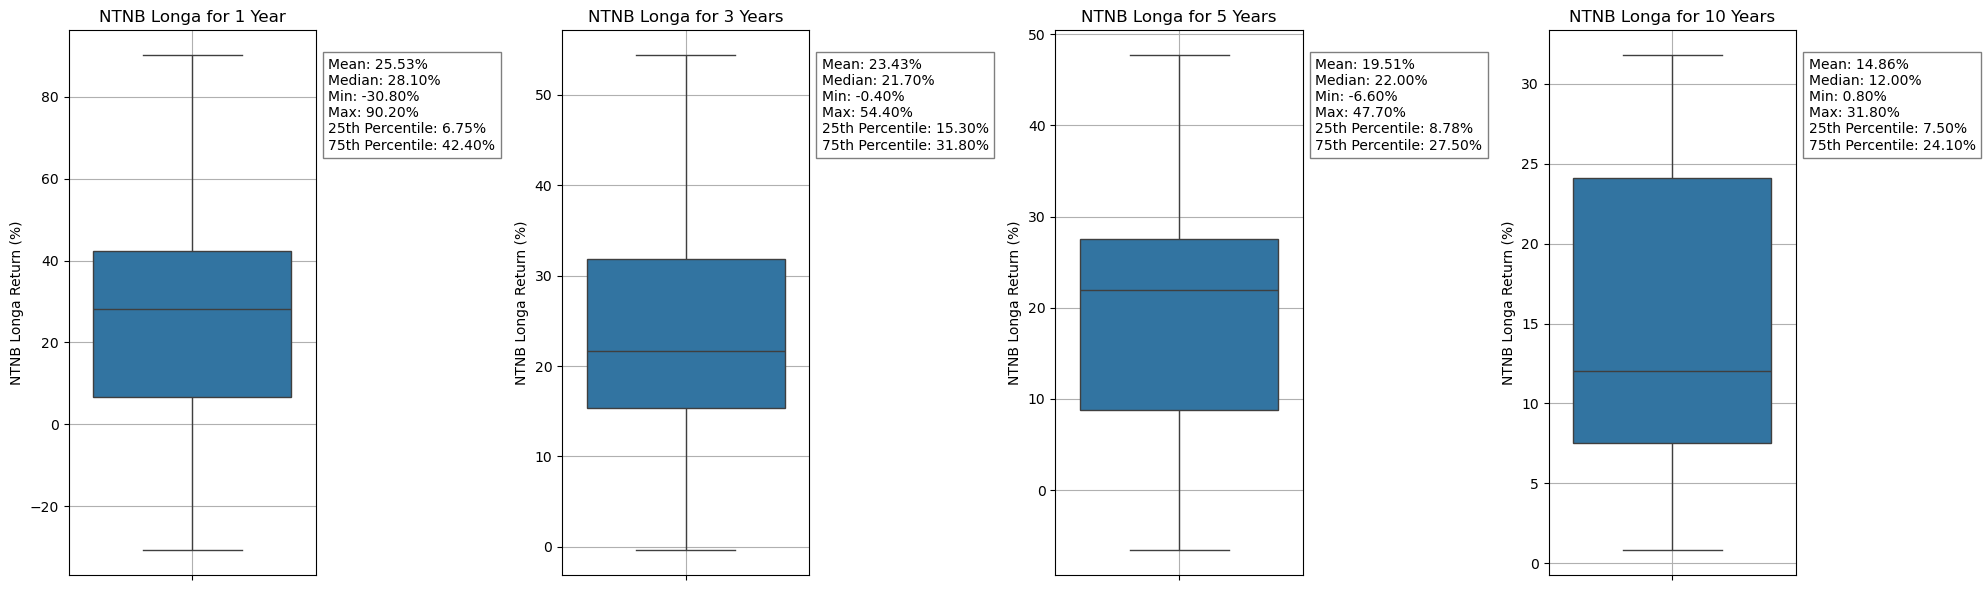

In [11]:
# Função para cruzar os dados filtrados e gerar o boxplot para os períodos
def boxplot_ntnb_performance(df_original, df_period, ntnb_threshold, period_label, ax):
    # Filtra os dados no DataFrame original onde 'NTN-B' é maior que o valor predefinido (ntnb_threshold)
    filtered_original = df_original[df_original['NTN-B'] > ntnb_threshold]
    
    if filtered_original.empty:
        print(f"No data found where NTN-B is greater than {ntnb_threshold} in the original data. Please adjust the threshold.")
        return

    # Filtra os dados nos DataFrames de período, mantendo as datas coincidentes com o filtro original
    filtered_period = df_period[df_period['Datas de Entrada'].isin(filtered_original['Dates'])]
    
    if filtered_period.empty:
        print(f"No matching data found in {period_label} for NTN-B > {ntnb_threshold}.")
        return
    
    # Verificar se existem dados suficientes para cálculo de quartis
    if len(filtered_period['NTNB Longa']) < 2:
        print(f"Not enough data to compute quartiles in {period_label}.")
        return

    # Gerar o boxplot para a performance da coluna "NTNB Longa"
    sns.boxplot(data=filtered_period['NTNB Longa'], ax=ax)
    ax.set_title(f'NTNB Longa for {period_label}')
    ax.set_ylabel('NTNB Longa Return (%)')
    ax.grid(True)

    # Calcular estatísticas
    mean_performance = filtered_period['NTNB Longa'].mean()
    median_performance = filtered_period['NTNB Longa'].median()
    min_performance = filtered_period['NTNB Longa'].min()
    max_performance = filtered_period['NTNB Longa'].max()
    quartiles_performance = np.percentile(filtered_period['NTNB Longa'].dropna(), [25, 75])  # Garantindo que não há NaNs
    
    # Adicionar texto com estatísticas no gráfico
    stats_text = (f"Mean: {mean_performance:.2f}%\n"
                  f"Median: {median_performance:.2f}%\n"
                  f"Min: {min_performance:.2f}%\n"
                  f"Max: {max_performance:.2f}%\n"
                  f"25th Percentile: {quartiles_performance[0]:.2f}%\n"
                  f"75th Percentile: {quartiles_performance[1]:.2f}%")
    
    # Exibe o texto no gráfico no canto superior direito
    ax.text(1.05, 0.95, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5), fontsize=10)

# Definir um valor para o limiar de "NTN-B"
ntnb_threshold = 0.06  # Por exemplo, 6%

# Criar subplots lado a lado
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

# Chamar a função para os diferentes períodos, cada um em um subplot
boxplot_ntnb_performance(df_original, df_1_year, ntnb_threshold, "1 Year", axes[0])
boxplot_ntnb_performance(df_original, df_3_years, ntnb_threshold, "3 Years", axes[1])
boxplot_ntnb_performance(df_original, df_5_years, ntnb_threshold, "5 Years", axes[2])
boxplot_ntnb_performance(df_original, df_10_years, ntnb_threshold, "10 Years", axes[3])

# Ajustar o layout dos subplots
plt.tight_layout()
plt.show()


## Boxplot com input(números inteiros)

Enter threshold value for NTN-B as an integer percentage (e.g., 6 for 6%):  6.4


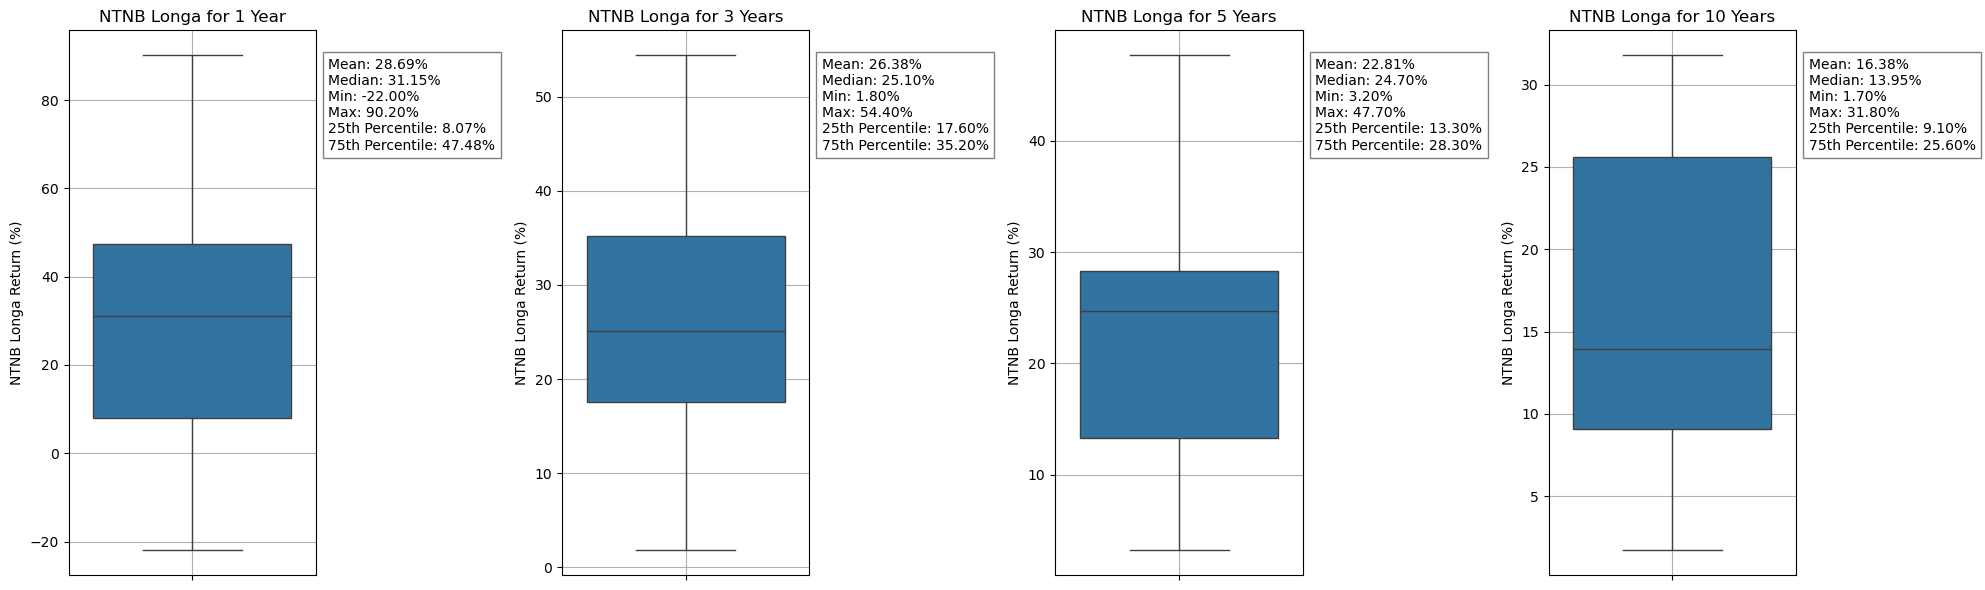

In [17]:
# Função para cruzar os dados filtrados e gerar o boxplot para os períodos
def boxplot_ntnb_performance(df_original, df_period, ntnb_threshold, period_label, ax):
    # Filtra os dados no DataFrame original onde 'NTN-B' é maior que o valor predefinido (ntnb_threshold)
    filtered_original = df_original[df_original['NTN-B'] > ntnb_threshold]
    
    if filtered_original.empty:
        print(f"No data found where NTN-B is greater than {ntnb_threshold} in the original data. Please adjust the threshold.")
        return

    # Filtra os dados nos DataFrames de período, mantendo as datas coincidentes com o filtro original
    filtered_period = df_period[df_period['Datas de Entrada'].isin(filtered_original['Dates'])]
    
    if filtered_period.empty:
        print(f"No matching data found in {period_label} for NTN-B > {ntnb_threshold}.")
        return
    
    # Verificar se existem dados suficientes para cálculo de quartis
    if len(filtered_period['NTNB Longa']) < 2:
        print(f"Not enough data to compute quartiles in {period_label}.")
        return

    # Gerar o boxplot para a performance da coluna "NTNB Longa"
    sns.boxplot(data=filtered_period['NTNB Longa'], ax=ax)
    ax.set_title(f'NTNB Longa for {period_label}')
    ax.set_ylabel('NTNB Longa Return (%)')
    ax.grid(True)

    # Calcular estatísticas
    mean_performance = filtered_period['NTNB Longa'].mean()
    median_performance = filtered_period['NTNB Longa'].median()
    min_performance = filtered_period['NTNB Longa'].min()
    max_performance = filtered_period['NTNB Longa'].max()
    quartiles_performance = np.percentile(filtered_period['NTNB Longa'].dropna(), [25, 75])  # Garantindo que não há NaNs
    
    # Adicionar texto com estatísticas no gráfico
    stats_text = (f"Mean: {mean_performance:.2f}%\n"
                  f"Median: {median_performance:.2f}%\n"
                  f"Min: {min_performance:.2f}%\n"
                  f"Max: {max_performance:.2f}%\n"
                  f"25th Percentile: {quartiles_performance[0]:.2f}%\n"
                  f"75th Percentile: {quartiles_performance[1]:.2f}%")
    
    # Exibe o texto no gráfico no canto superior direito
    ax.text(1.05, 0.95, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5), fontsize=10)

# Função que atualiza os gráficos com base no threshold inserido pelo usuário
def update_boxplot(threshold):
    # Criar subplots lado a lado
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))

    # Chamar a função para os diferentes períodos, cada um em um subplot
    boxplot_ntnb_performance(df_original, df_1_year, threshold, "1 Year", axes[0])
    boxplot_ntnb_performance(df_original, df_3_years, threshold, "3 Years", axes[1])
    boxplot_ntnb_performance(df_original, df_5_years, threshold, "5 Years", axes[2])
    boxplot_ntnb_performance(df_original, df_10_years, threshold, "10 Years", axes[3])

    # Ajustar o layout dos subplots
    plt.tight_layout()
    plt.show()

# Entrada manual para o valor do threshold (como inteiro)
threshold_input = float(input("Enter threshold value for NTN-B as an integer percentage (e.g., 6 for 6%): "))

# Converter o valor do input para a forma correta dividindo por 100
threshold_value = threshold_input / 100.0

# Atualizar o gráfico com o valor inserido
update_boxplot(threshold_value)


### Exportando CSV NTNB_Longa_Periods

In [93]:

# Criar um dicionário com os DataFrames para cada período
df_periods = {
    "1 Year": df_1_year,
    "3 Years": df_3_years,
    "5 Years": df_5_years,
    "10 Years": df_10_years
}

# Lista para armazenar os DataFrames ajustados
df_list = []

# Processar cada DataFrame e adicionar uma coluna com o período correspondente
for period, df in df_periods.items():
    df_temp = df.copy()  # Fazer uma cópia para evitar alterar o DataFrame original
    df_temp['Period'] = period  # Adicionar a coluna 'Period'
    df_list.append(df_temp[['Datas de Entrada', 'NTNB Longa', 'Period']])  # Selecionar as colunas desejadas e adicionar na lista

# Concatenar todos os DataFrames da lista em um único DataFrame
df_combined = pd.concat(df_list)

# Ordenar o DataFrame combinado por data, se necessário
df_combined = df_combined.sort_values(by=['Datas de Entrada', 'Period'])

# Mostrar ou salvar o DataFrame combinado
print(df_combined.head(20))  # Mostrar as primeiras 20 linhas para verificação

# Opcional: Salvar o DataFrame em um arquivo CSV
df_combined.to_csv('NTNB_Longa_Periods.csv', index=False)


  Datas de Entrada  NTNB Longa    Period
0       2000-01-28         NaN    1 Year
0       2000-01-28         NaN  10 Years
0       2000-01-28         NaN   3 Years
0       2000-01-28         NaN   5 Years
1       2000-02-04         NaN    1 Year
1       2000-02-04         NaN  10 Years
1       2000-02-04         NaN   3 Years
1       2000-02-04         NaN   5 Years
2       2000-02-11         NaN    1 Year
2       2000-02-11         NaN  10 Years
2       2000-02-11         NaN   3 Years
2       2000-02-11         NaN   5 Years
3       2000-02-18         NaN    1 Year
3       2000-02-18         NaN  10 Years
3       2000-02-18         NaN   3 Years
3       2000-02-18         NaN   5 Years
4       2000-02-25         NaN    1 Year
4       2000-02-25         NaN  10 Years
4       2000-02-25         NaN   3 Years
4       2000-02-25         NaN   5 Years
